<ipython-input-23-393a1daa715a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))


97
1 97
12513 13257
12513 10937
10937 7459
7459 7395


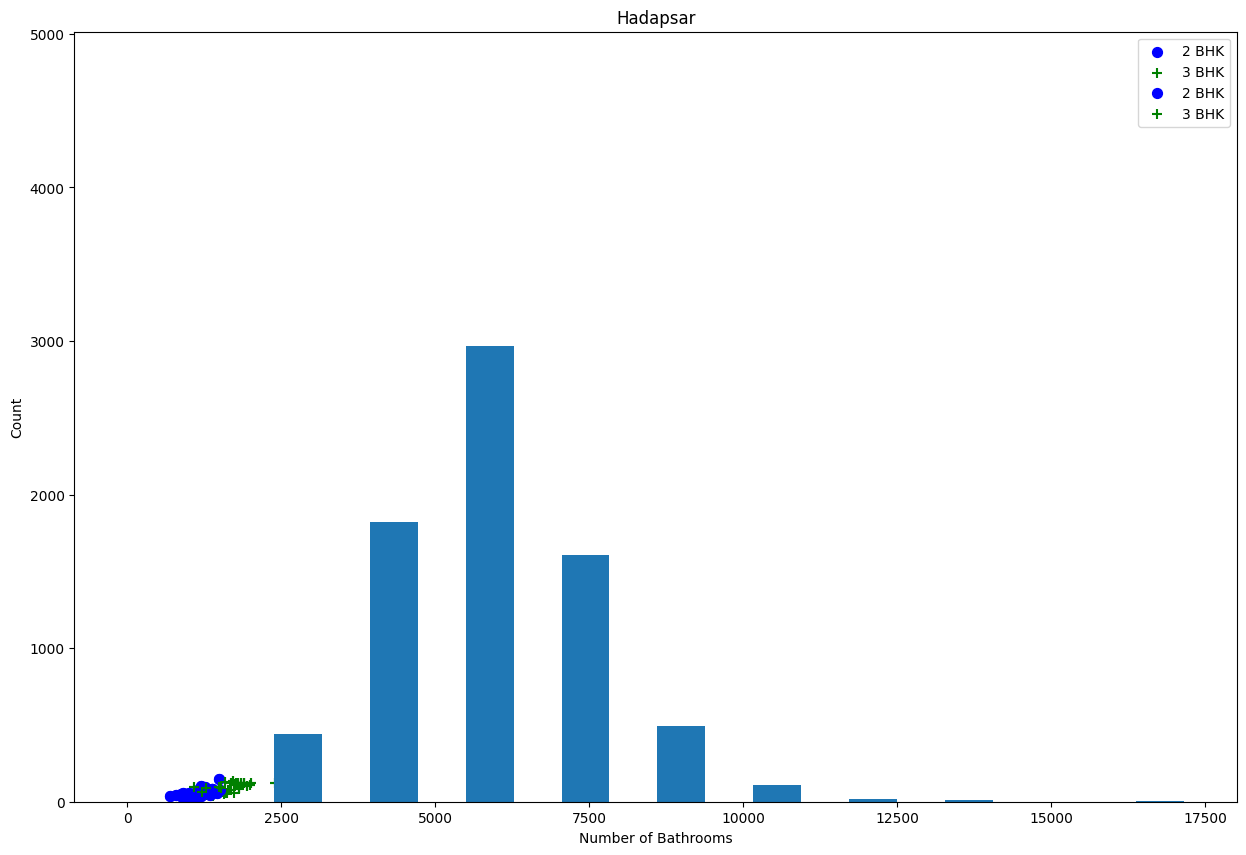

In [23]:
# Importing essential libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams as rcP
%matplotlib inline
# Loading the dataset
df = pd.read_csv('/content/pune_dataset.csv')
df.head()
# Exploring the dataset
df.shape
# Exploring the dataset
df.groupby('area_type')['area_type'].agg('count')
# Exploring the dataset
df.groupby('availability')['availability'].agg('count')
# Exploring the dataset
df.groupby('size')['size'].agg('count')
# Exploring the dataset
df.groupby('site_location')['site_location'].agg('count')
# Removing the columns of society
df = df.drop('society', axis='columns')
df.head()
## Data Cleaning Process
# Data Cleaning
# Checking the null values in the dataset
df.isnull().sum()
# Applying median to the balcony and bath column
from math import floor

balcony_median = float(floor(df.balcony.median()))
bath_median = float(floor(df.bath.median()))

df.balcony = df.balcony.fillna(balcony_median)
df.bath = df.bath.fillna(bath_median)
# Checking the null values in the dataset again
df.isnull().sum()
# Dropping the rows with null values because the dataset is huge as compared to null values.
df = df.dropna()
df.isnull().sum()
# Converting the size column to bhk
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df = df.drop('size', axis='columns')
df.groupby('bhk')['bhk'].agg('count')
# Exploring the total_sqft column
df.total_sqft.unique()
# Since the total_sqft contains range values such as 1133-1384, lets filter out these values
def isFloat(x):
    try:
        float(x)
    except:
        return False
    return True
# Displaying all the rows that are not integers
df[~df['total_sqft'].apply(isFloat)]
# Converting the range values to integer values and removing other types of error
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None
df['new_total_sqft'] = df.total_sqft.apply(convert_sqft_to_num)
df = df.drop('total_sqft', axis='columns')
df.head()
# Removing the rows in new_total_sqft column that hase None values
df.isna().sum()
# Removing the rows in new_total_sqft column that hase None values
df = df.dropna()
df.isna().sum()
## Feature Engineering
# Adding a new column of price_per_sqft
df1 = df.copy()

# In our dataset the price column is in Lakhs
df1['price_per_sqft'] = (df1['price']*100000)/df1['new_total_sqft']
df1.head()
# Checking unique values of 'location' column
locations = list(df['site_location'].unique())
print(len(locations))
# Removing the extra spaces at the end
df1.site_location = df1.site_location.apply(lambda x: x.strip())

# Calulating all the unqiue values in 'site_location' column
location_stats = df1.groupby('site_location')['site_location'].agg('count').sort_values(ascending=False)
location_stats
# Checking locations with less than 10 values
print(len(location_stats[location_stats<=10]), len(df1.site_location.unique()))
df1.head()
# Labelling the locations with less than or equal to 10 occurences to 'other'
locations_less_than_10 = location_stats[location_stats<=10]

df1.site_location = df1.site_location.apply(lambda x: 'other' if x in locations_less_than_10 else x)
len(df1.site_location.unique())
# Checking the unique values in 'availability column'
df1.groupby('availability')['availability'].agg('count').sort_values(ascending=False)
# Labelling the dates into Not Ready
dates = df1.groupby('availability')['availability'].agg('count').sort_values(ascending=False)

dates_not_ready = dates[dates<10000]
df1.availability = df1.availability.apply(lambda x: 'Not Ready' if x in dates_not_ready else x)

len(df1.availability.unique())
df1.head()
# Checking the unique values in 'area_type' column
df1.groupby('area_type')['area_type'].agg('count').sort_values(ascending=False)

# Since the column has only few unique values, we don't perform any operation
## Removing Outliers
# Removing the rows that have 1 Room for less than 300sqft

df2 = df1[~(df1.new_total_sqft/df1.bhk<300)]
print(len(df2), len(df1))
df2.price_per_sqft.describe()
# Since there is a wide range for 'price_per_sqft' column with min = Rs.267/sqft till max = Rs. 127470/sqft, we remove the extreme ends using the SD
def remove_pps_outliers(df):

    df_out = pd.DataFrame()

    for key, sub_df in df.groupby('site_location'):
        m = np.mean(sub_df.price_per_sqft)
        sd = np.std(sub_df.price_per_sqft)
        reduce_df = sub_df[(sub_df.price_per_sqft>(m-sd)) & (sub_df.price_per_sqft<(m+sd))]
        df_out = pd.concat([df_out, reduce_df], ignore_index=True)

    return df_out

df3 = remove_pps_outliers(df2)
print(len(df2), len(df3))
def plot_scatter_chart(df, site_location):
    bhk2 = df[(df.site_location == site_location) & (df.bhk == 2)]
    bhk3 = df[(df.site_location == site_location) & (df.bhk == 3)]
    rcP['figure.figsize'] = (15,10)
    plt.scatter(bhk2.new_total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.new_total_sqft, bhk3.price, color='green', marker='+', label='3 BHK', s=50)
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Price (in Lakhs)')
    plt.title(site_location)
    plt.legend()

plot_scatter_chart(df3, 'Hadapsar')
# Here we observe that 3 BHK cost that same as 2 BHK in 'Hebbal' location hence removing such outliers is necessary
def remove_bhk_outliers(df):
    exclude_indices = np.array([])

    for site_location, site_location_df in df.groupby('site_location'):
        bhk_stats = {}

        for bhk, bhk_df in site_location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }

        for bhk, bhk_df in site_location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)

    return df.drop(exclude_indices, axis='index')

df4 = remove_bhk_outliers(df3)
print(len(df3), len(df4))
plot_scatter_chart(df4, 'Hadapsar')
plt.hist(df4.price_per_sqft, rwidth=0.5)
r2_=0.925148
plt.xlabel('Price Per Square Feet')
plt.ylabel('Count')
plt.hist(df4.bath, rwidth=0.5)
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count')
# Removing the rows that have 'bath' greater than 'bhk'+2
df5 = df4[df4.bath<(df4.bhk+2)]
print(len(df4), len(df5))
df5.tail()
## Model Building
# Removing the unnecessary columns (columns that were added only for removing the outliers)
df6 = df5.copy()
df6 = df6.drop('price_per_sqft', axis='columns')
df6.head()
# Converting the categorical_value into numerical_values using get_dummies method
dummy_cols = pd.get_dummies(df6.site_location)
df6 = pd.concat([df6,dummy_cols], axis='columns')

# Converting the categorical_value into numerical_values using get_dummies method
dummy_cols = pd.get_dummies(df6.essential_services_nearby)
df6 = pd.concat([df6,dummy_cols], axis='columns')




# Converting the categorical_value into numerical_values using get_dummies method
dummy_cols = pd.get_dummies(df6.availability).drop('Not Ready', axis='columns')
df6 = pd.concat([df6,dummy_cols], axis='columns')
# Converting the categorical_value into numerical_values using get_dummies method
dummy_cols = pd.get_dummies(df6.area_type).drop('Super built-up  Area', axis='columns')
df6 = pd.concat([df6,dummy_cols], axis='columns')
df6.drop(['area_type','availability','site_location','essential_services_nearby','crime_rate'], axis='columns', inplace=True)
df6.head(10)
# Size of the dataset
df6.shape
# Splitting the dataset into features and label
X = df6.drop('price', axis='columns')
y = df6['price']

# Since the Linear Regression has the highest accuracy, the model selected for this problem is Linear Regression
# Splitting the dataset into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)
# Creating Linear Regression Model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)
# Predicting the values using our trained model
X.columns
# For finding the appropriate location
np.where(X.columns=='Balaji Nagar')[0][0]
# For finding the appropriate area_type
np.where(X.columns=='Built-up  Area')[0][0]
# For finding the appropriate availability
np.where(X.columns=='Ready To Move')[0][0]
# Creating a fuction to predict values
def prediction(location, bhk, bath, balcony, sqft, area_type, availability):

    loc_index, area_index, avail_index = -1,-1,-1

    if location!='other':
        loc_index = int(np.where(X.columns==location)[0][0])

    if area_type!='Super built-up  Area':
        area_index = np.where(X.columns==area_type)[0][0]

    if availability!='Not Ready':
        avail_index = np.where(X.columns==availability)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = bath
    x[1] = balcony
    x[2] = bhk
    x[3] = sqft

    if loc_index >= 0:
        x[loc_index] = 1
    if area_index >= 0:
        x[area_index] = 1
    if avail_index >= 0:
        x[avail_index] = 1

    return model.predict([x])[0]


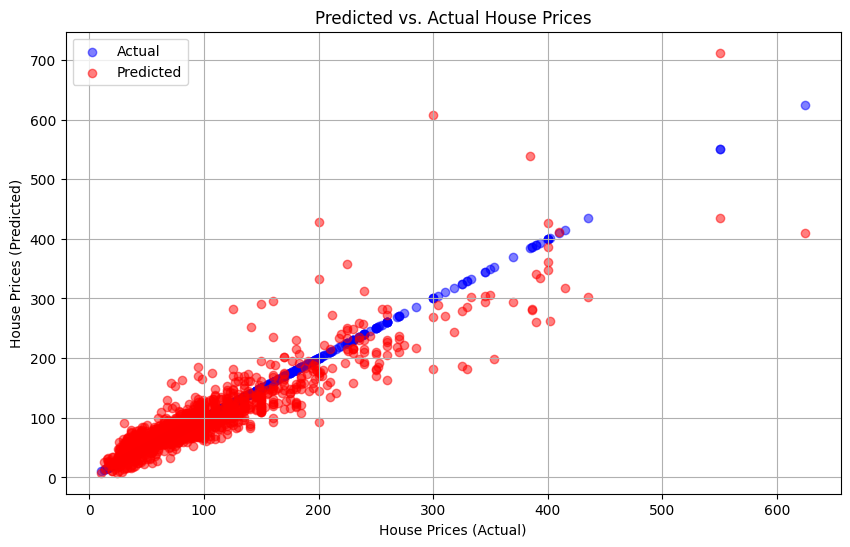

In [3]:
# Making predictions on the test data
y_pred = model.predict(X_test)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test, color='blue', label='Actual', alpha=0.5)
plt.scatter(y_test, y_pred, color='red', label='Predicted', alpha=0.5)
plt.title('Predicted vs. Actual House Prices')
plt.xlabel('House Prices (Actual)')
plt.ylabel('House Prices (Predicted)')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Prediction 1
# Input in the form : Location, BHK, Bath, Balcony, Sqft, area_type, availability.
prediction('Balaji Nagar', 2, 2, 2, 1000, 'Built-up  Area', 'Ready To Move')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


52.182932747286785

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculating R-squared (R2)
r2 = r2_score(y_test, y_pred)

# Calculating Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 15.602812108084615
R-squared (R2): 0.8711100745875575
Root Mean Squared Error (RMSE): 23.80563352682021


In [10]:
# Input in the form : Location, BHK, Bath, Balcony, Sqft, area_type, availability.
prediction('Camp', 2, 3, 2, 2000, 'Plot  Area', 'Not Ready')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


140.15408260581302

In [ ]:
# Input in the form : Location, BHK, Bath, Balcony, Sqft, area_type, availability.
prediction('Baner', 2, 3, 2, 2000, 'Plot  Area', 'Not Ready')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


140.17341345557801

In [11]:
# Splitting the dataset into features (X) and target variable (y)
X = df6.drop('price', axis='columns')
y = df6['price']


# Splitting the dataset into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

# Importing RandomForestRegressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor

# Creating a function to build and train the Random Forest model
def build_random_forest_model(X_train, y_train):
    # Instantiate RandomForestRegressor
    rf = RandomForestRegressor()

    # Train the model
    rf.fit(X_train, y_train)

    return rf

# Building the Random Forest model
random_forest_model = build_random_forest_model(X_train, y_train)

# Evaluating the model
random_forest_model.score(X_test, y_test)

rf=RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

# Predict function for Random Forest
def random_forest_prediction(location, bhk, bath, balcony, sqft, area_type, availability):
    loc_index, area_index, avail_index = -1,-1,-1

    if location!='other':
        loc_index = int(np.where(X.columns==location)[0][0])

    if area_type!='Super built-up  Area':
        area_index = np.where(X.columns==area_type)[0][0]

    if availability!='Not Ready':
        avail_index = np.where(X.columns==availability)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = bath
    x[1] = balcony
    x[2] = bhk
    x[3] = sqft

    if loc_index >= 0:
        x[loc_index] = 1
    if area_index >= 0:
        x[area_index] = 1
    if avail_index >= 0:
        x[avail_index] = 1

    return random_forest_model.predict([x])[0]

# Testing Random Forest predictions
# Prediction 1
random_forest_prediction('Balaji Nagar', 2, 2, 2, 1000, 'Built-up  Area', 'Ready To Move')


# Prediction 2
random_forest_prediction('Hadapsar', 2, 2, 2, 1000, 'Super built-up  Area', 'Ready To Move')



# Prediction 3
random_forest_prediction('Camp', 2, 3, 2, 2000, 'Plot  Area', 'Not Ready')


# Prediction 4
random_forest_prediction('Baner', 2, 3, 2, 2000, 'Plot  Area', 'Not Ready')
# Evaluating the model
random_forest_model.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


0.8745980217661042

In [25]:
# Importing essential libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import tree
import matplotlib.pyplot as plt



# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, mae, r2, rmse

# Evaluating the model
mse, mae, r2, rmse = evaluate_model(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Root Mean Squared Error (RMSE):", rmse)




Mean Absolute Error (MAE): 15.602812108084615
R-squared (R2): 0.8711100745875575
Root Mean Squared Error (RMSE): 23.80563352682021


In [27]:
# Splitting the dataset into features (X) and target variable (y)
X = df6.drop('price', axis='columns')
y = df6['price']


# Splitting the dataset into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)


# Training both Linear Regression and Random Forest models
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

random_forest_model = build_random_forest_model(X_train, y_train)

# Obtaining predictions from both models
linear_regression_predictions = linear_regression_model.predict(X_test)
random_forest_predictions = random_forest_model.predict(X_test)

# Defining weights for each model
linear_regression_weight = 0.2
random_forest_weight = 0.8

# Calculate the weighted average of the predictions
weighted_predictions = (linear_regression_weight * linear_regression_predictions) + (random_forest_weight * random_forest_predictions)

# Evaluate the accuracy of the final model
from sklearn.metrics import r2_score,accuracy_score
final_model_accuracy = r2_score(y_test, weighted_predictions)


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predicting on the test set
ensemble_predictions = linear_regression_weight * linear_regression_model.predict(X_test) + random_forest_weight * random_forest_model.predict(X_test)

# Calculating evaluation metrics
mse = mean_squared_error(y_test, weighted_predictions)
mae = mean_absolute_error(y_test, weighted_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,weighted_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2_)


Mean Absolute Error (MAE): 15.400769362728418
Root Mean Squared Error (RMSE): 23.63780279491984
R-squared (R2) Score: 0.925148


In [29]:
from sklearn.metrics import mean_absolute_error

# Calculate the Mean Absolute Error (MAE) for the final model
mae = mean_absolute_error(y_test, weighted_predictions)

# Print the MAE
print("Mean Absolute Error (MAE) of the final model:", mae)


Mean Absolute Error (MAE) of the final model: 15.400769362728418
